## Quick Tutorial: Using Bayesian optimization to tune your hyperparameters in PyTorch

https://towardsdatascience.com/quick-tutorial-using-bayesian-optimization-to-tune-your-hyperparameters-in-pytorch-e9f74fc133c2

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

cuda:0


|          | 0/? [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


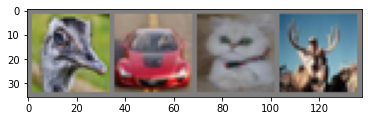

 bird   car   cat  deer


In [3]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
def net_train(net, train_loader, parameters, dtype, device):
    net.to(dtype=dtype, device=device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001), # 0.001 is used if no lr is specified
                        momentum=parameters.get("momentum", 0.9)
    )

    scheduler = optim.lr_scheduler.StepLR(
      optimizer,
      step_size=int(parameters.get("step_size", 30)),
      gamma=parameters.get("gamma", 1.0),  # default is no learning rate decay
    )

    num_epochs = parameters.get("num_epochs", 3) # Play around with epoch number
    # Train Network
    for _ in range(num_epochs):
        for inputs, labels in train_loader:
            # move data to proper dtype and device
            inputs = inputs.to(dtype=dtype, device=device)
            labels = labels.to(device=device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
    return net

In [5]:
def init_net(parameterization):

    model = torchvision.models.resnet50(pretrained=True) #pretrained ResNet50

    # The depth of unfreezing is also a hyperparameter
    for param in model.parameters():
        param.requires_grad = False # Freeze feature extractor
        
    Hs = 512 # Hidden layer size; you can optimize this as well
                                  
    model.fc = nn.Sequential(nn.Linear(2048, Hs), # attach trainable classifier
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(Hs, 10),
                                 nn.LogSoftmax(dim=1))
    return model # return untrained model

In [6]:
def train_evaluate(parameterization):

    # constructing a new training data loader allows us to tune the batch size
    train_loader = torch.utils.data.DataLoader(trainset,
                                batch_size=parameterization.get("batchsize", 32),
                                shuffle=True,
                                num_workers=0,
                                pin_memory=True)
    
    # Get neural net
    untrained_net = init_net(parameterization) 
    
    # train
    trained_net = net_train(net=untrained_net, train_loader=train_loader, 
                            parameters=parameterization, dtype=dtype, device=device)
    
    # return the accuracy of the model as it was trained in this run
    return evaluate(
        net=trained_net,
        data_loader=testloader,
        dtype=dtype,
        device=device,
    )

In [ ]:
#torch.cuda.set_device(0) #this is sometimes necessary for me
dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
        {"name": "batchsize", "type": "range", "bounds": [16, 128]},
        {"name": "momentum", "type": "range", "bounds": [0.0, 1.0]},
        #{"name": "max_epoch", "type": "range", "bounds": [1, 30]},
        #{"name": "stepsize", "type": "range", "bounds": [20, 40]},        
    ],
  
    evaluation_function=train_evaluate,
    objective_name='accuracy',
    total_trials=20
)

print(best_parameters)
means, covariances = values
print(means)
print(covariances)

[INFO 01-26 10:13:09] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-26 10:13:09] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter batchsize. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-26 10:13:09] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter momentum. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 01-26 10:13:09] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[Sobol for 5 trials, GPEI for subsequent trials]). Iterations after 5 will take longer to generate due

  0%|          | 0.00/97.8M [00:00<?, ?B/s]

[INFO 01-26 10:14:28] ax.service.managed_loop: Running optimization trial 2...
[INFO 01-26 10:16:25] ax.service.managed_loop: Running optimization trial 3...
[INFO 01-26 10:17:41] ax.service.managed_loop: Running optimization trial 4...
[INFO 01-26 10:19:48] ax.service.managed_loop: Running optimization trial 5...
[INFO 01-26 10:22:11] ax.service.managed_loop: Running optimization trial 6...
[INFO 01-26 10:24:43] ax.service.managed_loop: Running optimization trial 7...
[INFO 01-26 10:27:28] ax.service.managed_loop: Running optimization trial 8...
[INFO 01-26 10:29:25] ax.service.managed_loop: Running optimization trial 9...
[INFO 01-26 10:32:15] ax.service.managed_loop: Running optimization trial 10...
[INFO 01-26 10:34:24] ax.service.managed_loop: Running optimization trial 11...
[INFO 01-26 10:36:10] ax.service.managed_loop: Running optimization trial 12...
[INFO 01-26 10:38:01] ax.service.managed_loop: Running optimization trial 13...
[INFO 01-26 10:39:46] ax.service.managed_loop: R